# Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import seaborn as sns

from datetime import datetime

import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow_privacy
from sklearn.metrics import mean_squared_error, mean_absolute_error,median_absolute_error
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy



# from Funciones_TesisV1 import LSTM_CON_PD
# from Funciones_TesisV1 import LSTM_SIN_DP

# Hacer funciones

## Función CON PD

In [155]:


"""**Prueba CON PD**"""
def LSTM_CON_PD(datos,fechas,nodos1,nodos2,paciencia,epocas,batch,window_size,t_pridiccion,norm_clip,ruido,microBatches,lr):

    
    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)



    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - window_size - t_pridiccion):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size:i+window_size+t_pridiccion])

        Xf.append(fechas[i:i+window_size])
        yf.append(fechas[i+window_size:i+window_size+t_pridiccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)


    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=0.1, shuffle=False)



    model = Sequential()

    model.add(LSTM(nodos1,activation= "tanh", input_shape=(window_size,1)))
    model.add(Dense(nodos2, activation="relu"))
    model.add(Dense(t_pridiccion , activation="linear"))

 

    if batch % microBatches != 0:
        raise ValueError('Batch size should be an integer multiple of the number of microbatches')



    # agregar la privacidad diferencial en el optimizador 
    optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=norm_clip,
        noise_multiplier=ruido,
        num_microbatches=microBatches,
        learning_rate=lr)

    # Función de pérdida para regresión
    loss = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.NONE)


    model.compile(optimizer=optimizer, loss=loss)

    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = 0.2, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])


    # guardar los archivo a usar en la carpeta 
    rutaAGuardar = f'Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas con PD.keras'
    model.save(rutaAGuardar)

    # hacer la predicción  y desestandarizar
    y_hat = model.predict(X_test, verbose=1)

    y_hat = estandarizacion.inverse_transform(y_hat)

    #desestandarizar y_test
    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,t_pridiccion,1)

    predicciones24 = []
    reales24 = []
    for i in range(t_pridiccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test1:
            real.append(reales[i])
            
        predicciones24.append(pred)
        reales24.append(real)
        



    MAES = {}
    RMSE = {}
    ER_Medios = {}
    ER_Medianos = {}
    epsilon = 1e-10
    for i in range(t_pridiccion):
        MAE = round(mean_absolute_error(predicciones24[i],reales24[i]),2)
        MSE = round(mean_squared_error(reales24[0],predicciones24[i]),2)
        Error_Relativo_Medio = round((np.mean(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
        Error_Relativo_Mediano = round((np.median(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
        
        
        MAES[i] = MAE
        RMSE[i] = np.sqrt(MSE)
        ER_Medianos[i] = Error_Relativo_Mediano
        ER_Medios[i] = Error_Relativo_Medio

        


    return history, y_hat,y_test1,fecha_y_test, MAES,RMSE,ER_Medianos,ER_Medios,X_train.shape[0]


## Función sin PD

In [124]:

"""**Prueba SIN PD**"""
def LSTM_SIN_DP(datos,fechas,nodos1,nodos2,paciencia,epocas,batch,window_size,t_pridiccion,lr):

        
    estandarizacion = MinMaxScaler().fit(datos)
    scaled_data = estandarizacion.transform(datos)



    # dividir en train, test
    X, y = [], []
    Xf,yf = [],[]

    for i in range(len(scaled_data) - window_size - t_pridiccion):
        X.append(scaled_data[i:i+window_size])
        y.append(scaled_data[i+window_size:i+window_size+t_pridiccion])

        Xf.append(fechas[i:i+window_size])
        yf.append(fechas[i+window_size:i+window_size+t_pridiccion])

    X, y = np.array(X), np.array(y)
    Xf,yf = np.array(Xf),np.array(yf)




    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    fecha_X_train, fecha_X_test, fecha_y_train, fecha_y_test = train_test_split(Xf, yf, test_size=0.1, shuffle=False)
        
    model = Sequential()

    model.add(LSTM(nodos1,activation= "tanh", input_shape=(window_size,1)))
    model.add(Dense(nodos2, activation="relu"))
    model.add(Dense(t_pridiccion , activation="linear"))

    model.compile(optimizer="Adam", loss='mse')

    early_stopping = EarlyStopping(monitor='loss', patience=paciencia, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=epocas,validation_split = 0.2, verbose=1, batch_size=batch,shuffle = False, callbacks=[early_stopping])



    # guardar los archivo a usar en la carpeta 
    rutaAGuardar = f'Modelo {nodos1} - nodos1 - {nodos2} - nodos2 - {epocas} Epocas sin PD.keras'
    model.save(rutaAGuardar)


        
    y_hat = model.predict(X_test, verbose=1)
    y_hat = estandarizacion.inverse_transform(y_hat)

    y_test1 = y_test.reshape(-1, 1)

    y_test1 = estandarizacion.inverse_transform(y_test1)

    y_test1 = y_test1.reshape(-1,t_pridiccion,1)


    predicciones24 = []
    reales24 = []
    for i in range(t_pridiccion):
            
        pred = []
        for Predicciones in y_hat:
            pred.append(Predicciones[i])
            
        real = []
        for reales in y_test1:
            real.append(reales[i])
            
        predicciones24.append(pred)
        reales24.append(real)
        



    MAES = {}
    RMSE = {}
    ER_Medios = {}
    ER_Medianos = {}
    epsilon = 1e-10
    for i in range(t_pridiccion):
        MAE = round(mean_absolute_error(predicciones24[i],reales24[i]),2)
        MSE = round(mean_squared_error(reales24[0],predicciones24[i]),2)
        Error_Relativo_Medio = round((np.mean(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
        Error_Relativo_Mediano = round((np.median(np.abs((np.array(reales24[i]) - np.array(predicciones24[i])) / (np.array(reales24[i])+epsilon)))*100),2)
        
        
        MAES[i] = MAE
        RMSE[i] = np.sqrt(MSE)
        ER_Medianos[i] = Error_Relativo_Mediano
        ER_Medios[i] = Error_Relativo_Medio


    return history, y_hat,y_test1,fecha_y_test, MAES,RMSE,ER_Medianos,ER_Medios




# Abrir archivos

In [95]:
### baguette es el que más vende
df = pd.read_csv("C:\\Users\\jd.pradal\\OneDrive - Universidad de los andes\\Documentos\\Maestría\\TESIS JUAN DIEGO PRADA\\Tesis 2\\Código\\\Descarga Datos K\\french Bakery sales\\Bakery sales.csv")

df =df[df['article']== "TRADITIONAL BAGUETTE"]
df = df[['date','article','Quantity']]
# df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# df = df[(df['product']==1) & (df['store'] ==0)]
# df.sort_values(by='Date',inplace = True)

df = df.groupby('date')['Quantity'].sum().reset_index()
df
# df

,date,Quantity
0,2021-01-02,128.0
1,2021-01-03,171.0
2,2021-01-04,128.0
3,2021-01-05,99.0
4,2021-01-07,109.0
...,...,...
595,2022-09-26,160.0
596,2022-09-27,136.0
597,2022-09-28,115.0
598,2022-09-29,148.0


# Graficar datos

<function matplotlib.pyplot.show(close=None, block=None)>

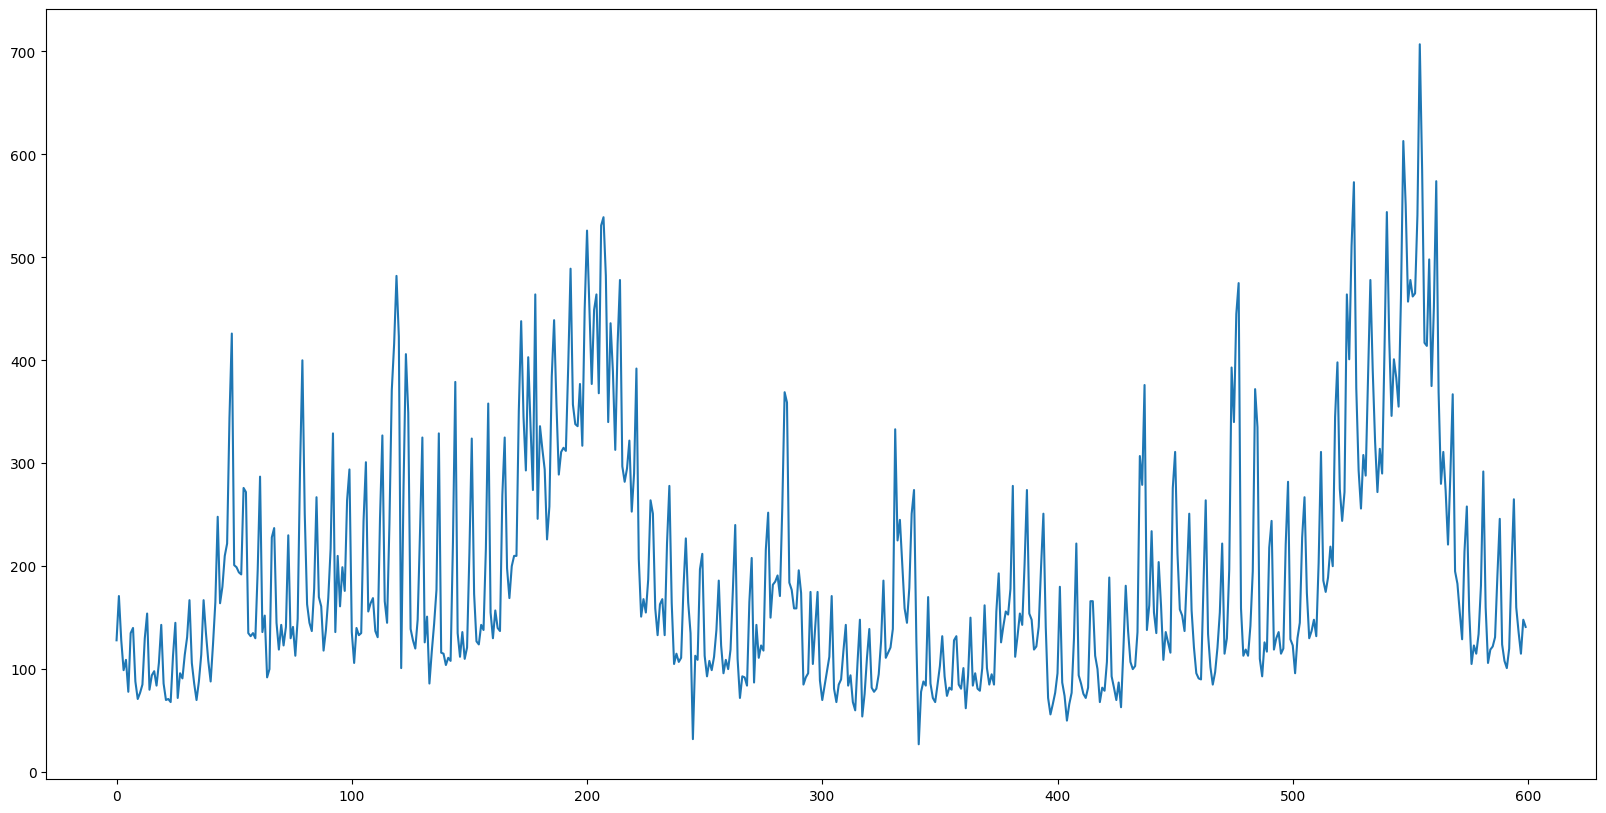

In [96]:

plt.figure(figsize=(20,10))
plt.plot(df['Quantity'][:])
plt.show

# Seleccionar datos para modelo

<function matplotlib.pyplot.show(close=None, block=None)>

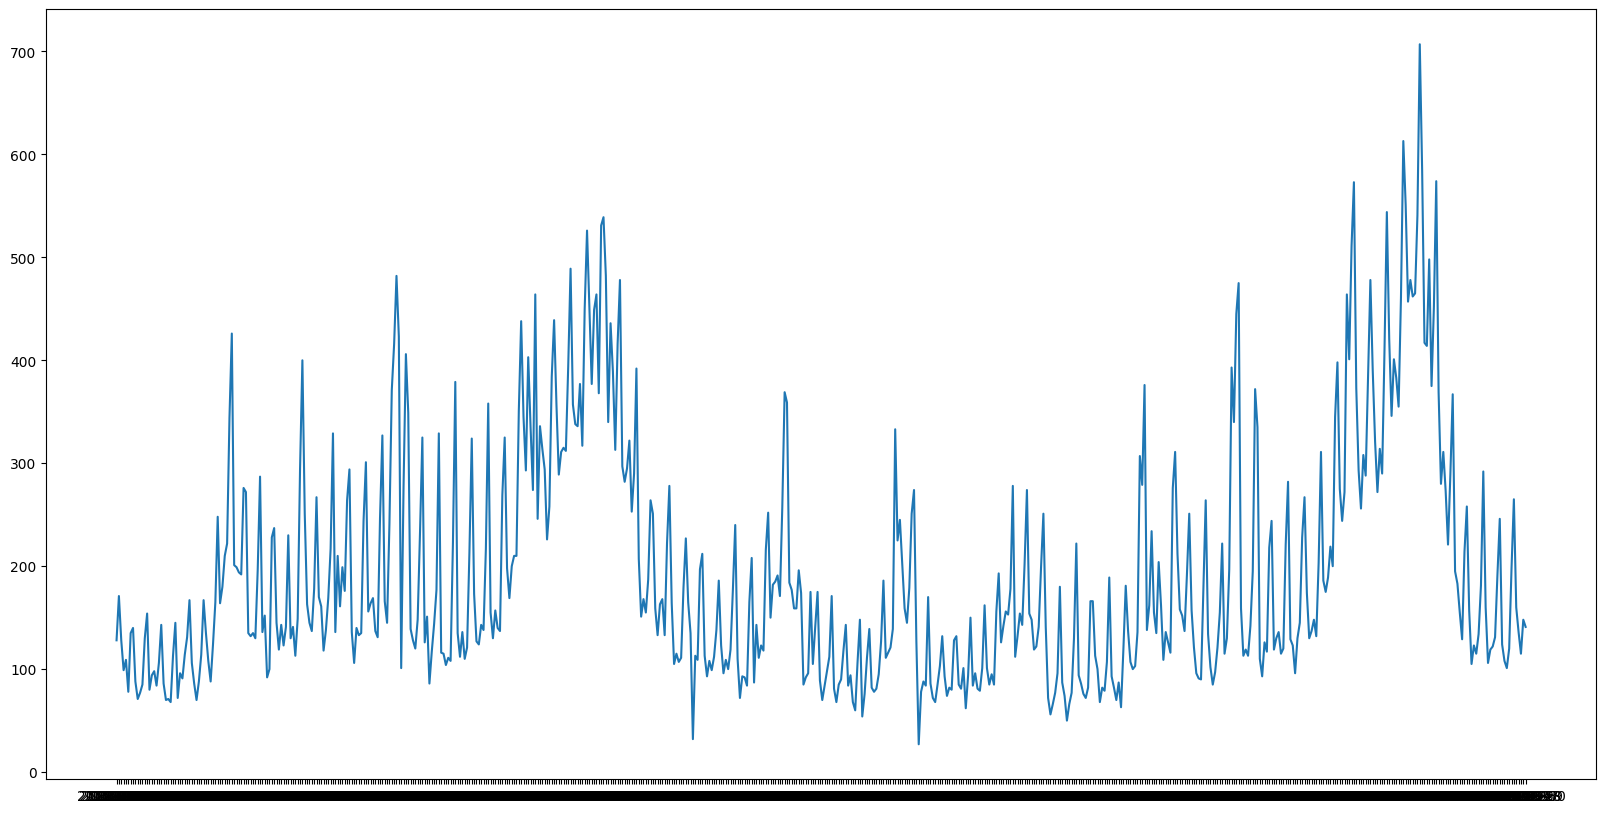

In [84]:
dfModelo = df.iloc[:,:]

plt.figure(figsize=(20,10))
plt.plot(dfModelo['date'][:], dfModelo['Quantity'][:])
plt.show

In [97]:
datos = dfModelo['Quantity'].to_numpy()
fechas = dfModelo['date'].to_numpy()
datos = datos.reshape(-1,1)
datos = datos[:-7]

len(datos)

593

In [113]:
estandarizacion = MinMaxScaler().fit(datos)
scaled_data = estandarizacion.transform(datos)

window_size = 7
t_pridiccion = 1


# dividir en train, test
X, y = [], []
Xf,yf = [],[]

for i in range(len(scaled_data) - window_size - t_pridiccion):
    X.append(scaled_data[i:i+window_size])
    y.append(scaled_data[i+window_size:i+window_size+t_pridiccion])

    Xf.append(fechas[i:i+window_size])
    yf.append(fechas[i+window_size:i+window_size+t_pridiccion])

X, y = np.array(X), np.array(y)
Xf,yf = np.array(Xf),np.array(yf)




X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [114]:
len(X_train)

526

In [115]:
len(X_train)*0.8

420.8

In [116]:
len(X_train)*0.8/batch

13.15

In [102]:
# len(X_train)*0.8/batch

# Correr Modelo

In [174]:
# Parámetros
batch = 32
nodos1 = 80
nodos2 =80
lr = 0.0001
paciencia = 15
epocas = 40
window_size = 7
t_pridiccion = 1

l2_norm_clip = 2
noise_multiplier = 10
num_microbatches = 4
learning_rate = 0.0001





In [175]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples = n, # Aquí usamos 'num_examples' en lugar de 'n'
    batch_size=batch,
    noise_multiplier=noise_multiplier,
    delta=1e-5,
    num_epochs = epocas
)

print(f"Epsilon: {epsilon}")


Epsilon: DP-SGD performed over 526 examples with 32 examples per iteration, noise
multiplier 10 for 40 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:         6.208
    Epsilon assuming Poisson sampling (*):                      1.325

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



In [149]:
historySPD, y_hatSPD,y_test1SPD,fecha_y_testSPD, MAES_SPD,RMSE_SPD,ER_Medianos_SPD,ER_Medios_SPD = LSTM_SIN_DP(datos,fechas,nodos1,nodos2,paciencia,epocas,batch,window_size,t_pridiccion,learning_rate)

Epoch 1/130
14/14 [==============================] - 3s 47ms/step - loss: 0.0443 - val_loss: 0.0227
Epoch 2/130
14/14 [==============================] - 0s 9ms/step - loss: 0.0142 - val_loss: 0.0187
Epoch 3/130
14/14 [==============================] - 0s 8ms/step - loss: 0.0122 - val_loss: 0.0189
Epoch 4/130
14/14 [==============================] - 0s 7ms/step - loss: 0.0112 - val_loss: 0.0185
Epoch 5/130
14/14 [==============================] - 0s 7ms/step - loss: 0.0099 - val_loss: 0.0191
Epoch 6/130
14/14 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0194
Epoch 7/130
14/14 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0195
Epoch 8/130
14/14 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0192
Epoch 9/130
14/14 [==============================] - 0s 8ms/step - loss: 0.0097 - val_loss: 0.0191
Epoch 10/130
14/14 [==============================] - 0s 8ms/step - loss: 0.0096 - val_loss: 0.0191
Epoch 11

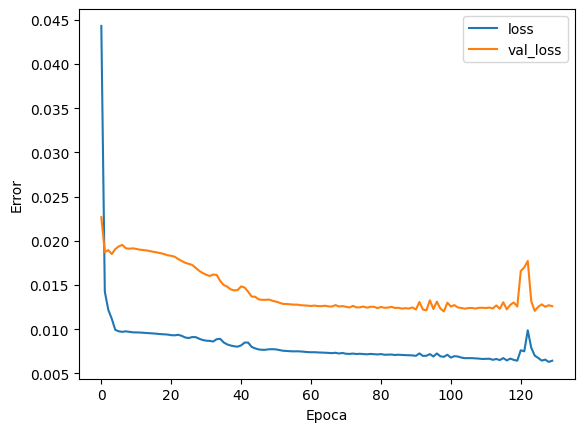

In [150]:

plt.plot(historySPD.history['loss'], label='loss')
plt.plot(historySPD.history['val_loss'], label='val_loss')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()

In [176]:

historyCPD, y_hatCPD,y_test1CPD,fecha_y_testCPD, MAES_CPD,RMSE_CPD,ER_Medianos_CPD,ER_Medios_CPD,n = LSTM_CON_PD(datos,fechas,nodos1,nodos2,paciencia,epocas,batch,window_size,t_pridiccion,l2_norm_clip,noise_multiplier,num_microbatches,learning_rate)

Epoch 1/40
14/14 [==============================] - 7s 36ms/step - loss: 0.0817 - val_loss: 0.0850
Epoch 2/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0802 - val_loss: 0.0822
Epoch 3/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0792 - val_loss: 0.0823
Epoch 4/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0809 - val_loss: 0.0858
Epoch 5/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0828 - val_loss: 0.0854
Epoch 6/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0810 - val_loss: 0.0841
Epoch 7/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0809 - val_loss: 0.0836
Epoch 8/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0806 - val_loss: 0.0824
Epoch 9/40
14/14 [==============================] - 0s 8ms/step - loss: 0.0770 - val_loss: 0.0776
Epoch 10/40
14/14 [==============================] - 0s 9ms/step - loss: 0.0744 - val_loss: 0.0770
Epoch 11/40
14/14 

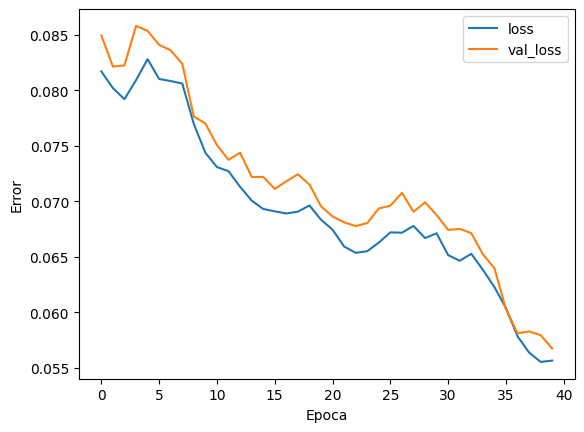

In [177]:

plt.plot(historyCPD.history['loss'], label='loss')
plt.plot(historyCPD.history['val_loss'], label='val_loss')
plt.xlabel('Epoca')
plt.ylabel('Error')
plt.legend()

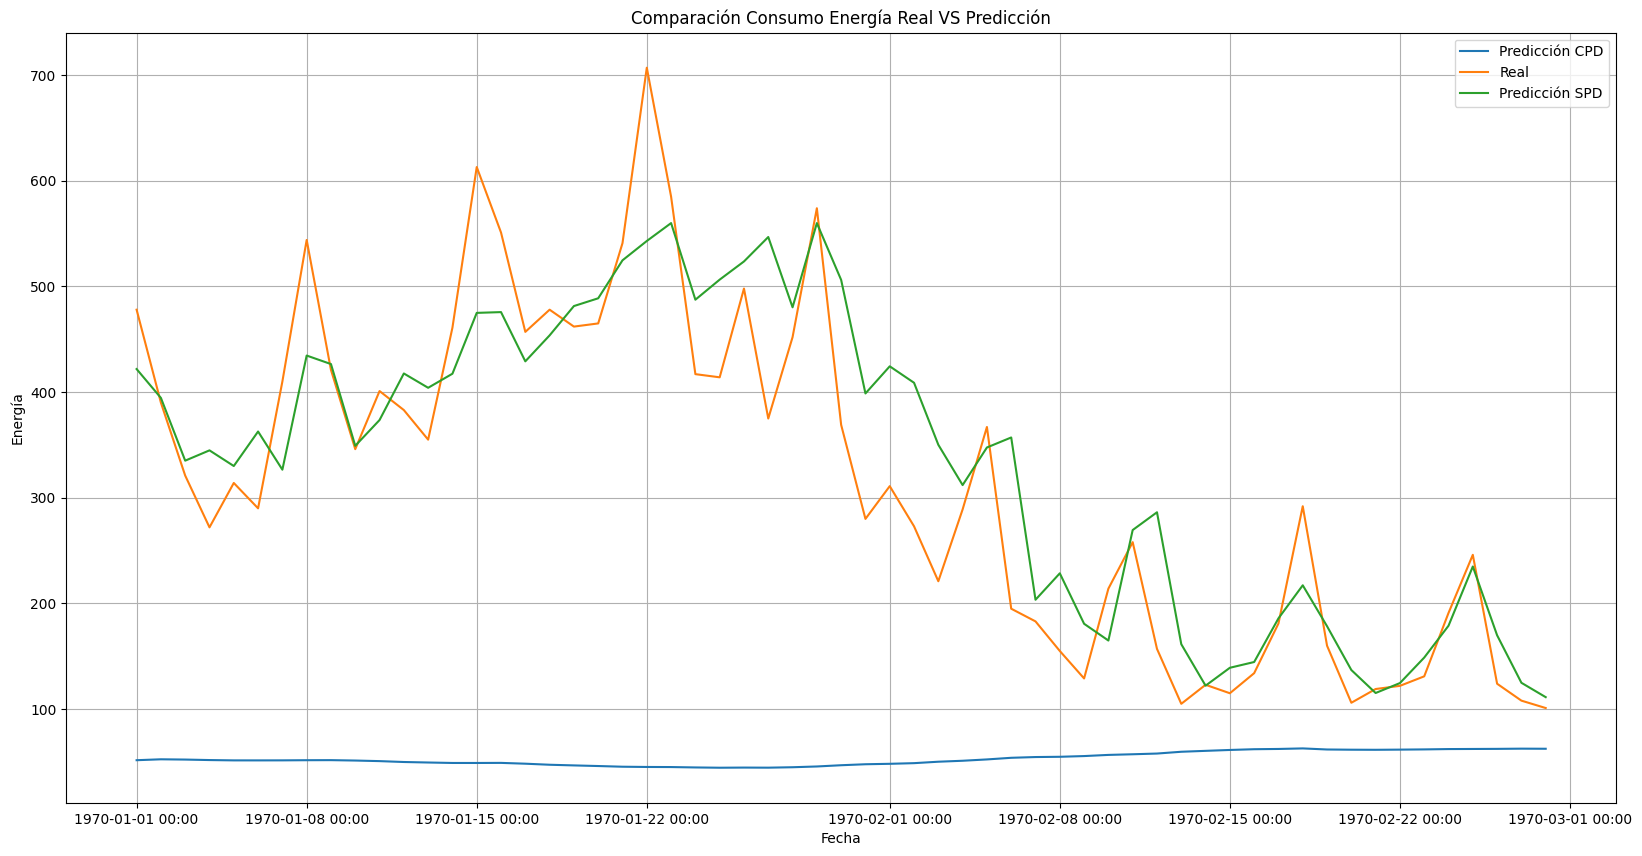

In [178]:

num = 2
plt.figure(figsize=(20,10))
plt.title("Comparación Consumo Energía Real VS Predicción")
plt.plot(fecha_y_testCPD.reshape(-1),y_hatCPD.reshape(-1),label = "Predicción CPD")
plt.plot(fecha_y_testCPD.reshape(-1),y_test1CPD.reshape(-1),label = "Real")
plt.plot(fecha_y_testSPD.reshape(-1),y_hatSPD.reshape(-1),label = "Predicción SPD")

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())



plt.ylabel("Energía")
plt.xlabel("Fecha")
plt.grid()
plt.legend()
plt.show()

In [157]:
from tensorflow_privacy.privacy.analysis.compute_dp_sgd_privacy_lib import compute_dp_sgd_privacy_statement

# Parámetros correctos para la función
epsilon = compute_dp_sgd_privacy_statement(
    number_of_examples = n, # Aquí usamos 'num_examples' en lugar de 'n'
    batch_size=batch,
    noise_multiplier=noise_multiplier,
    delta=1e-5,
    num_epochs = epocas
)

print(f"Epsilon: {epsilon}")


Epsilon: DP-SGD performed over 526 examples with 32 examples per iteration, noise
multiplier 2 for 130 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:       117.688
    Epsilon assuming Poisson sampling (*):                     23.553

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.



In [ ]:
MAES_CPD

In [ ]:
RMSE_CPD

In [ ]:
ER_Medianos_CPD

In [ ]:
ER_Medios_CPD

# Imprimir todas las predicciones

In [ ]:
fig = plt.figure(figsize=(25, 130))
ax = fig.subplots(14,1)

for i in range(14):
    ax[i].set_title(f'Comparación Consumo Energía Real VS Predicción - {29*i}')
    ax[i].set_xlabel("Fecha")
    ax[i].set_ylabel("Energía")
    ax[i].plot(fecha_y_test[29*(i)],y_hat[29*(i)],label = "Predicción")
    ax[i].plot(fecha_y_test[29*(i)],estandarizacion.inverse_transform(y_test[29*(i)]),label = "Real")
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H'))
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.setp(ax[i].xaxis.get_majorticklabels(), rotation=15)
    ax[i].legend()
    ax[i].grid()
    
